# Example: background selection


# Setting up the simulation
* Neutral mutations will occur on the interval $[0,1)$.
* Strongly-deleterious mutations will occur on the intervals $[-1,0)$ and $[1,2)$.
* Recombination will be uniform throughout the region.

In [1]:
#Import the package:
%matplotlib inline 
%pylab inline 
from __future__ import print_function
import fwdpy as fp
import numpy as np
import pandas
import math

Populating the interactive namespace from numpy and matplotlib


In [2]:
#We're going to do some plots at the end.
import matplotlib
import matplotlib.pyplot as plt

## Establishing 'regions' for mutation and recombination


In [3]:
# Where neutral mutations occur:
nregions = [fp.Region(beg=0,end=1,weight=1)]

In [4]:
# Where selected mutations occur:
sregions = [fp.ConstantS(beg=-1,end=0,weight=1,s=-0.05,h=1),
            fp.ConstantS(beg=1,end=2,weight=1,s=-0.05,h=1)]

In [5]:
# Recombination:
recregions = [fp.Region(beg=-1,end=2,weight=1)]

## Population size and simulation length

In [6]:
#Population size
N=1000
#We'll evolve for 10N generations.
#nlist is a list of population sizes over time.
#len(nlist) is the length of the simulation
#We use numpy arrays for speed and optimised RAM
#use.  Note the dtype=np.uint32, which means 32-bit
#unsigned integer. Failure to use this type will
#cause a run-time error.
nlist = np.array([N]*10*N,dtype=np.uint32)

In [7]:
#Initalize a random number generator with seed value of 101
rng = fp.GSLrng(101)

In [8]:
#Simulate 4 replicate populations.  This uses C++11 threads behind the scenes:
pops = fp.evolve_regions(rng,       #The random number generator 
                         4,         #The number of pops to simulate = number of threads to use.
                         N,         #Initial population size for each of the 4 demes
                         nlist[0:], #List of population sizes over time.
                         0.005,     #Neutral mutation rate (per gamete, per generation)
                         0.01,      #Deleterious mutation rate (per gamete, per generation)
                         0.005,     #Recombination rate (per diploid, per generation)
                         nregions,  #Defined above
                         sregions,  #Defined above
                         recregions)#Defined above

In [9]:
#Now, pops is a Python list with len(pops) = 4
#Each element's type is fwdpy.singlepop
print(len(pops))
for i in range(len(pops)):
    print(type(pops[i]))
                

4
<type 'fwdpy.fwdpy.singlepop'>
<type 'fwdpy.fwdpy.singlepop'>
<type 'fwdpy.fwdpy.singlepop'>
<type 'fwdpy.fwdpy.singlepop'>


# Taking samples from simulated populations

In [10]:
#Use a list comprehension to get a random sample of size
#n = 20 from each replicate
samples = [fp.get_samples(rng,i,20) for i in pops]

#Samples is now a list of tuples of two lists.
#Each list contains tuples of mutation positions and genotypes.
#The first list represents neutral variants.
#The second list represents variants affecting fitness ('selected' variants)
#We will manipulate/analyze these genotypes, etc.,
#in a later example
for i in samples:
    print ("A sample from a population is a ",type(i))
    
print(len(samples))

A sample from a population is a  <type 'tuple'>
A sample from a population is a  <type 'tuple'>
A sample from a population is a  <type 'tuple'>
A sample from a population is a  <type 'tuple'>
4


## Getting additional information about samples

In [11]:
#Again, use list comprehension to get the 'details' of each sample
#Given that each object in samples is a tuple, and that the second
#item in each tuple represents selected mutations, i[1] in the line
#below means that we are getting the mutation information only for
#selected variants
details = [fp.get_sample_details(i[1],j) for i,j in zip(samples,pops)]

In [12]:
#details is now a list of pandas DataFrame objects
#Each DataFrame has the following columns:
#  a: mutation age (in generations)
#  h: dominance of the mutation
#  p: frequency of the mutation in the population
#  s: selection coefficient of the mutation
for i in details:
    print(i)

    a  h       p     s
0  35  1  0.0075 -0.05
1   8  1  0.0040 -0.05
2  18  1  0.0030 -0.05
    a  h       p     s
0  19  1  0.0100 -0.05
1  13  1  0.0025 -0.05
    a  h       p     s
0  10  1  0.0090 -0.05
1  29  1  0.0060 -0.05
2  15  1  0.0035 -0.05
    a  h       p     s
0   1  1  0.0005 -0.05
1  20  1  0.0065 -0.05
2  33  1  0.0080 -0.05
3   1  1  0.0005 -0.05


In [13]:
#The order of the rows in each DataFrame is the
#same as the order as the objects in 'samples':
for i in range(len(samples)):
    print("Number of sites in samples[",i,"] = ",
          len(samples[i][1]),". Number of rows in DataFrame ",i,
          " = ",len(details[i].index),sep="")

Number of sites in samples[0] = 3. Number of rows in DataFrame 0 = 3
Number of sites in samples[1] = 2. Number of rows in DataFrame 1 = 2
Number of sites in samples[2] = 3. Number of rows in DataFrame 2 = 3
Number of sites in samples[3] = 4. Number of rows in DataFrame 3 = 4


In [14]:
#Pandas DataFrames are cool.
#Let's add a column to each DataFrame
#specifying the mutation position,
#count of derived state,
#and a "replicate ID"
for i in range(len(details)):
    ##samples[i][1] again is the selected mutations in the sample taken
    ##from the i-th replicate
    details[i]['pos']=[x[0] for x in samples[i][1]]               #Mutation position
    details[i]['count']=[ x[1].count('1') for x in samples[i][1]] #No. occurrences of derived state in sample
    details[i]['id']=[i]*len(details[i].index)                    #Replicate id

In [15]:
##Merge into 1 big DataFrame:
BigTable = pandas.concat(details)

print("This is the merged table:")
print(BigTable)

This is the merged table:
    a  h       p     s       pos  count  id
0  35  1  0.0075 -0.05  1.191983      1   0
1   8  1  0.0040 -0.05  1.629000      1   0
2  18  1  0.0030 -0.05  1.721135      1   0
0  19  1  0.0100 -0.05  1.232333      1   1
1  13  1  0.0025 -0.05  1.710726      1   1
0  10  1  0.0090 -0.05 -0.743740      1   2
1  29  1  0.0060 -0.05 -0.513952      1   2
2  15  1  0.0035 -0.05 -0.283127      1   2
0   1  1  0.0005 -0.05 -0.734266      1   3
1  20  1  0.0065 -0.05 -0.004909      1   3
2  33  1  0.0080 -0.05  1.460910      1   3
3   1  1  0.0005 -0.05  1.698163      1   3


# Summary statistics from samples

Currently, there is limited support for summary statistic calculation in fwdpy.
KRT is still deciding whether or not to put it here or to make a lightweight
Cython interface to the relevant part of libsequence.

In [16]:
#So far, what we can do is calculate Tajima's D:

DvalsNeutral = [fp.TajimasD(i[0]) for i in samples]
DvalsSelected = [fp.TajimasD(i[1]) for i in samples]
print("The distribution of D for neutral variants:",DvalsNeutral)
print("The distribution of D for selected variants:",DvalsSelected)

The distribution of D for neutral variants: [0.4713569885638867, -0.7189286593474936, -0.3046935287892466, -0.5657062948639776]
The distribution of D for selected variants: [-1.7233097760082894, -1.5128356903928148, -1.7233097760082894, -1.867877699838809]


We don't need to wait for KRT to help us, though. Summary stats are easy to code up:

In [17]:
###fxn to ask if a site is a derived singleton
def isSingleton( site ):
    ones=site[1].count('1')
    if ones == 1:
        return True
    return False

##fxn to count derived singletonss in a sample
def countDerived( sample ):
    nsing=0
    for i in range(len(sample)):
        if isSingleton(sample[i]):
            nsing += 1
    return nsing

##fxn to calculate "pi" at a site
def pisite( site ):
    ssh = 0.0 #sum of site homozygosity
    ones=site[1].count('1')
    nsam=len(site[1])
    p1=float(ones)/float(nsam)
    p2=float(ones-1)/float(nsam-1)
    ssh = ssh + p1*p2
    zeroes=site[1].count('0')
    p1=float(zeroes)/float(nsam)
    p2=float(zeroes-1)/float(nsam-1)
    ssh = ssh + p1*p2
    return 1.-ssh

##Calculate pi for whole sample
def pisample(sample):
    pivals = [pisite(i) for i in sample]
    return sum(pivals)

##Apply our new functions:

##No. singletons at neutral sites
nsing = [countDerived(i[0]) for i in samples]
#No. singletons at selected sites
ssing = [countDerived(i[1]) for i in samples]
##Pi at neutral sites
pn = [pisample(i[0]) for i in samples]
##Pi at selected sites
ps = [pisample(i[1]) for i in samples]

print("Dist. of number of derived neutral singletons is:",nsing)
print("Dist. of number of derived selected singletons is:",ssing)
print("Dist. of pi at neutral mutations is:",pn)
print("Dist. of pi at selected mutations is:",ps)

Dist. of number of derived neutral singletons is: [14, 13, 14, 15]
Dist. of number of derived selected singletons is: [3, 2, 3, 4]
Dist. of pi at neutral mutations is: [20.447368421052641, 11.342105263157888, 15.378947368421047, 11.868421052631579]
Dist. of pi at selected mutations is: [0.30000000000000027, 0.20000000000000018, 0.30000000000000027, 0.40000000000000036]


## The average $\pi$ under the model

Under the BGS model, the expectation of $\pi$ is $E[\pi]=\pi_0e^{-\frac{U}{2sh+r}},$ $U$ is the mutation rate to strongly-deleterious variants, $\pi_0$ is the value expected in the absence of BGS (_i.e._ $\pi_0 = \theta = 4N_e\mu$), $s$ and $h$ are the selection and dominance coefficients, and $r$ is the recombination rate.

Note that the definition of $U$ is _per diploid_, meaning twice the per gamete rate. (See Hudson and Kaplan (1995) PMC1206891 for details).

For our parameters, we have $E[\pi] = 20e^{-\frac{0.02}{0.1+0.005}},$ which equals:

In [18]:
print(20*math.exp(-0.02/(0.1+0.005)))

16.5313087525


Now, let's get the average $\pi$ from 500 simulated replicates.  We already have four replicates that we did above, so we'll run another 124 sets of four populations.  

We will use standard Python to grow "pn", which is our list of $\pi$ values calculated from neutral mutations from each replicate.

In [19]:
for i in range(0,124,1):
    pops = fp.evolve_regions(rng,  
                         4,        
                         N,        
                         nlist[0:],
                         0.005,    
                         0.01,     
                         0.005,    
                         nregions, 
                         sregions, 
                         recregions)
    pn.extend([pisample(i[0]) for i in [fp.get_samples(rng,j,20) for j in pops]])

print("The mean pi at neutral sites is:",sum(pn)/float(len(pn)),"based on",len(pn),"replicates.")

The mean pi at neutral sites is: 16.3589684211 based on 500 replicates.


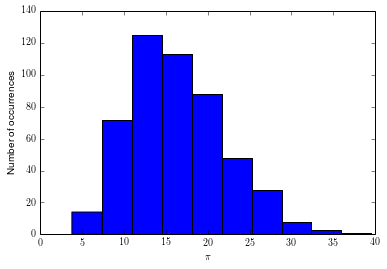

In [21]:
#Now, let's plot a histogram of the pi values 
n, bins, patches=plt.hist(pn)
plt.rc('text', usetex=True)
plt.xlabel(r'\pi')
plt.ylabel("Number of occurrences")
plt.show()